## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построить модель для такого предсказания.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

### План работы:
[1. Подготовка данных](#Подготовка) <br/>
[2. Анализ](#Анализ) <br/>
[3. Обучение](#Обучение) <br/>
3.1. Создание признаков и обучающей, тестовой наборов данных <br/>
3.2. Модель линейной регрессии <br/>
3.3. Модель случайный лес <br/>
[4. Тестирование](#Тестирование) <br/>
4.1. RMSE на тестовой выборке <br/>
4.2. Проверка качества <br/>
[Выводы](#Выводы) <br/>

# 1. Подготовка данных <a class="anchor" id="Подготовка"></a>

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
import os
import urllib.request

import sklearn
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import warnings 
warnings.filterwarnings('ignore')

In [2]:
#загружаем данные
Path('datasets').mkdir(parents=True, exist_ok=True)

def get_file(file_name, url):
    if not os.path.exists(file_name):
        print(file_name, 'файл не найден, будет загружен из сети')
        _=urllib.request.urlretrive(url, file_name)
        
urls = {
    'taxi': ('/datasets/taxi.csv', 'https://code.s3.yandex.net/datasets/taxi.csv')
}

[get_file(*urls[k]) for k in urls]

df = pd.read_csv(urls['taxi'][0], parse_dates=[0], index_col=[0])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
#посмотрим на описательную статистику признака
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [4]:
#отсортирум индекс и затем проведем проверку
df.sort_index(inplace=True)
df.index.is_monotonic

True

- При загрузке данных сразу изменили типа данных datetime с object на datetime64 и установили в качестве индекса датафрейма, которые впоследствии отсортировали в хронологическом порядке с 1 марта по 31 августа 2018 года
- Всего 26 496 записей в таблице: в среднем было совершено 14 заказов, стандартное отклонение 9, максимальное количество заказов - 119

# 2. Анализ  <a class="anchor" id="Анализ"></a>

In [5]:
#ресемплируем выборку и вычислим сумму сгруппированных значений за каждый час
df = df.resample('1H').sum()

Выполнили ресемплирование по одному часу

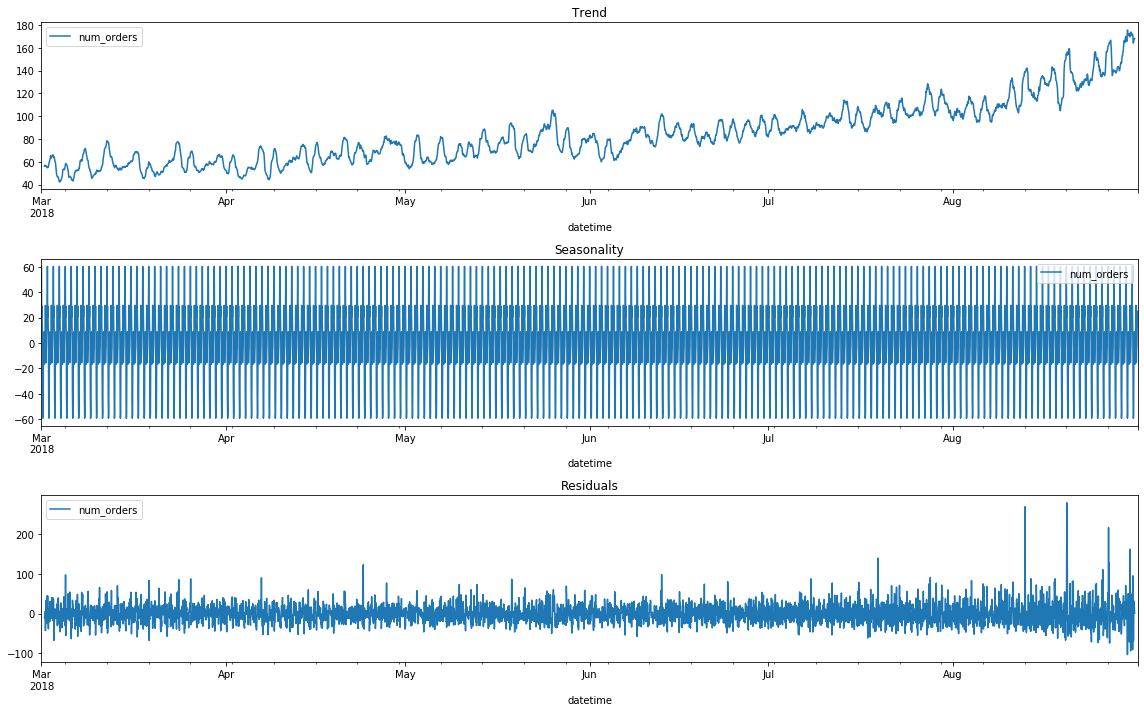

In [6]:
#разложим временной ряд на тренд и сезонную компоненту
decomposed = seasonal_decompose(df)
plt.figure(figsize=(16,10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

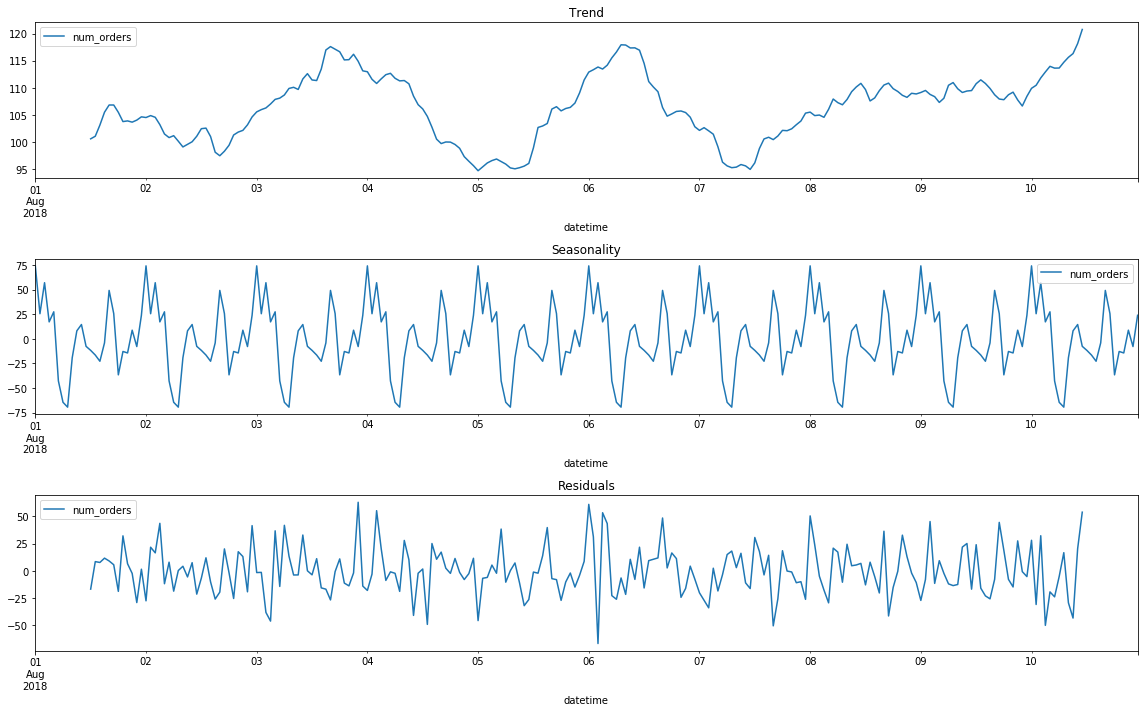

In [7]:
df_aug = df['2018-08-01':'2018-08-10']
decomposed = seasonal_decompose(df_aug)
plt.figure(figsize=(16,10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

- Прослеживает месячная сезонность, а именно увеличение спроса к осеннему времени: возможно, связано с тем, что многие возвращаются из отпусков и началом нового учебного года
- Внутрисуточная сезонность - самый пик приходится на полночь
- Остатки необъяснимы, т.е. это то, что нельзя уже предсказать.

# 3. Обучение <a class="anchor" id="Обучение"></a>

## 3.1. Создание признаков и обучающей, тестовой наборов данных <a class="anchor" id="Создание признаков и обучающей, тестовой наборов данных"></a>

In [8]:
#функция для создания 2 календарных признаков, вычисления отстающих значений и скользящего среднего
def make_features(data, max_lag, rolling_mean_size):
    '''
    data - исходная таблица с данными
    max_lag - максимальный размер отставания
    rolling_mean_size - ширина окна
    '''
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [9]:
#добавляем признаки и выведем первые 7 записей
make_features(df, 24, 3)
df.head(7)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.333333
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.000000
2018-03-01 05:00:00,6,3,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.000000
2018-03-01 06:00:00,12,3,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.333333


In [10]:
#разбили данные на обучающую, тестовую и проверим их размеры
train, test = train_test_split(df, shuffle=False, test_size=0.1)
display(train.index.min(), train.index.max())
display(test.index.min(), test.index.max())

Timestamp('2018-03-01 00:00:00')

Timestamp('2018-08-13 13:00:00')

Timestamp('2018-08-13 14:00:00')

Timestamp('2018-08-31 23:00:00')

In [11]:
#из обучающей выборки удаляем все строки с пропусками
train.dropna(inplace=True)
train.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,79.000000
2018-03-02 01:00:00,120,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,87.000000
2018-03-02 02:00:00,75,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,89.333333
2018-03-02 03:00:00,64,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,95.000000
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,86.333333


In [12]:
#в выборках выделили признаки и целевой признак
x_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
x_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

Данные готовы для обучения и тестирования моделей:
- Создали новые временные признаки на основе индекса
- Разделили данные на обучающую и тестовую выборку в соотношении 9:1
- В выборках выделили признаки и целевой признак

## 3.2. Модель линейной регрессии <a class="anchor" id="Модель линейной регрессии"></a>

In [13]:
#обучим модель линейной регрессии, предскажем результаты и посчитаем метрику качества
model_1 = LinearRegression()
model_1.fit(x_train, y_train)
model_1_pred = model_1.predict(x_train)
print('RMSE на обучающей выборке {:.2f} '.format(np.sqrt(mean_squared_error(model_1_pred, y_train))))

RMSE на обучающей выборке 25.84 


Отличный результат средней RMSE у модели линейной регрессии - 25.84

## 3.3. Модель случайный лес <a class="anchor" id="Модель случайный лес"></a>

In [14]:
%%time
params = {'n_estimators': [20, 500, 100],
          'max_depth': [10, 100, 300],
          'min_samples_split': [2, 5, 10]}

model_2 = RandomForestRegressor(random_state = 42)

best_score = 48
for g in ParameterGrid(params):
    model_2.set_params(**g)
    model_2.fit(x_train, y_train)
    model_2_pred = model_2.predict(x_train)
    RMSE_current = np.sqrt(mean_squared_error(model_2_pred, y_train))
    if RMSE_current < best_score:
        best_score = RMSE_current
        best_params = g

print('RMSE {:.2f} '.format(best_score))
print('Гиперпараметры:', best_params)

RMSE 8.41 
Гиперпараметры: {'max_depth': 100, 'min_samples_split': 2, 'n_estimators': 500}
CPU times: user 5min 31s, sys: 571 ms, total: 5min 32s
Wall time: 5min 33s


In [15]:
#модель с лучшими гиперпараметрами
model_2_best = RandomForestRegressor(max_depth = 100, min_samples_split = 2, n_estimators = 500, random_state = 42)
model_2_best.fit(x_train, y_train)
pred_train_2_best = model_2_best.predict(x_train)
print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(pred_train_2_best, y_train))))

RMSE: 8.41


Бесспорный лидер по лучшему RMSE 8.41 - модель случайный лес с настроенными гиперпараметрами: глубина 100, минимальное количество выборок у листа 2 и число деревьев 500

# 4. Тестирование <a class="anchor" id="Тестирование"></a>

## 4.1. RMSE на тестовой выборке <a class="anchor" id="RMSE на тестовой выборке"></a>

In [16]:
%%time
#первая модель линейной регресии
model_1.fit(x_train, y_train)
pred_test_1 = model_1.predict(x_test)
print('RMSE линейной модели на тестовой выборке: {:.2f}'.format(np.sqrt(mean_squared_error(pred_test_1, y_test))))

RMSE линейной модели на тестовой выборке: 45.18
CPU times: user 27.8 ms, sys: 16 ms, total: 43.8 ms
Wall time: 10.1 ms


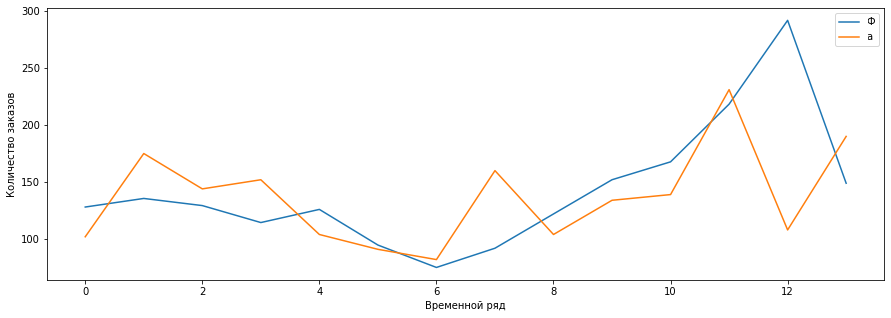

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(pred_test_1[:14])
plt.legend('Прогноз', loc='upper left')
plt.plot(np.array(y_test[:14]))
plt.legend('Факт')
plt.xlabel('Временной ряд')
plt.ylabel('Количество заказов')
plt.show()

In [18]:
%%time
#вторая модель случайного леса с лучшими гиперпараметрами
model_2_best.fit(x_train, y_train)
pred_test_2_best = model_2_best.predict(x_test)
print('RMSE модели случайный лес на тестовой выборке: {:.2f}'.format(np.sqrt(mean_squared_error(pred_test_2_best, y_test))))

RMSE модели случайный лес на тестовой выборке: 42.47
CPU times: user 35.2 s, sys: 28 ms, total: 35.2 s
Wall time: 35.3 s


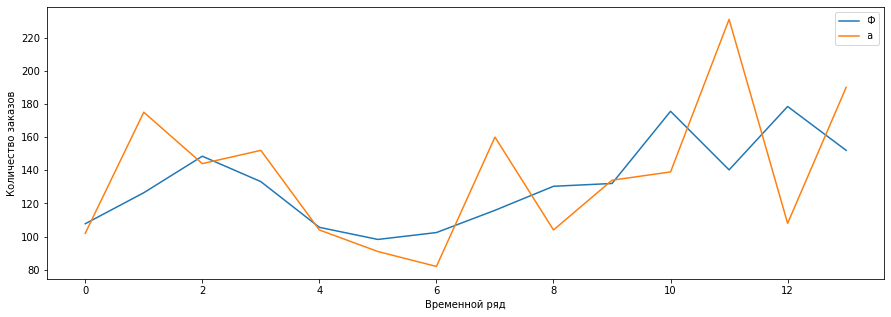

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(pred_test_2_best[:14])
plt.legend('Прогноз', loc='upper left')
plt.plot(np.array(y_test[:14]))
plt.legend('Факт')
plt.xlabel('Временной ряд')
plt.ylabel('Количество заказов')
plt.show()

На тестовой выборке RMSE двух моделей, как оказалось, не отличаются глобально - 42.47 у модели случайного леса и 45.18 у линейной регрессии

## 4.2. Проверка качества <a class="anchor" id="Проверка качества"></a>

In [20]:
#прогнозируем новое значение x(t) предыдущим значением ряда и вычислим по ней RMSE
pred_previous = y_test.shift(fill_value=y_train.iloc[-1])
print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(pred_previous, y_test))))

RMSE: 58.86


Проверка прошла успешно: мы убедились, что RMSE лучшей модели лучше результатов прогноза по предыдущим значением ряда 58.86

# Выводы <a class="anchor" id="Выводы"></a>

В рамках проекта была проделана следующая работа:
- При прочтении файла выяснили, что в данных содержится 26 496 наблюдений (заказов), записанных с 1 марта по 31 августа 2018 года
- Выполнили ресемплирование по одному часу и также  явно увидели тренд: повышение спроса к концу лета, что скорее всего связано с тем, что многие возвращаются из отпусков
- Подготовили наборы данных для моделей: создали новые временные признаки на основе индекса, разделили данные на обучающую и тестовую выборку в соотношении 9:1
- Обучили модель линейной регрессии и случайный лес, результаты RMSE 25.84 и 8.41 соотвественно. Для проверки качества построили прогноз по предыдущим значениям временного ряда
- По итогам на тестовой выборке лучшая модель для предсказания количества заказов такси на следующий час - это модель случайный лес по 2 параметрам: RMSE в рамках нашего бенчмарка 42.47 и при этом адекватная скорость предсказания.